In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

from clib.bellhop import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# Celerity profile selection

In [2]:
s = bellhop({'mediterrannee': './SSP_4profils.mat'},name='cognac_celerity',rmax=50.)
#s.params

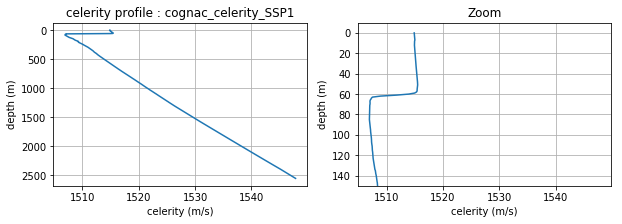

In [3]:
issp=0                                 # sound speed profile number
s.plotssp('mediterrannee', Issp=issp)

# Ray and Eigenray plots : 1 source and 1 receiver 

In [4]:
# Generate .env file R

s.params['file_type'] = 'R'           # ray tracing (.ray)
s.params['zs'] = 100.                 # source depth
s.params['ALimites'] = [-15.0, 15.0]  # limit angles    


s.generate_envfile('mediterrannee', file_env = s.params['name']+'_R.env', Issp=issp, SSP_depth_step=50)


Output file is : cognac_celerity_R.env


In [5]:
# Generate .env file E

s.params['file_type'] = 'E'           # 'E' : eigen rays (.rau) / 'A' : arrivals time and amplitude file (.arr)
s.params['zs'] = 100.                 # source depth
s.params['ALimites'] = [-90.0, 90.0]  # limit angles

s.params['NDepth'] = 1                # number of receiver depths
s.params['zmin'] = 500.               # minimum depth (m)
s.params['zmax'] = 1500.              # maximum depth (m) (unuseful if NDepth=1)
                 

s.params['NRange'] = 1                # number of receiver range    
s.params['rmin'] = 10.                # minimum range (km)
s.params['rmax'] = 30.                # maximum range (km) (unuseful if NRange=1)            

s.params['NBeams'] = 200000           # number of beams (if 0, bellhop choose automatically)

s.generate_envfile('mediterrannee', file_env = s.params['name']+'_E.env', Issp=issp, SSP_depth_step=50)


Output file is : cognac_celerity_E.env


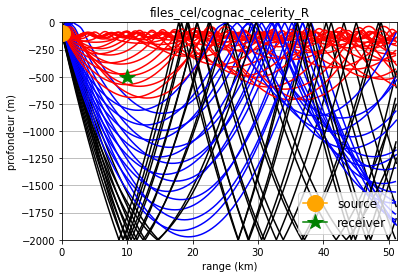

In [6]:
# ray tracing + location of source and receiver 
s.plotray('files_cel/cognac_celerity_R.ray')

plt.plot (0., -s.params['zs'], color='orange', marker='o', markersize=16, label = 'source')
plt.plot (s.params['rmin'], -s.params['zmin'], color='green', marker='*', markersize=16, label = 'receiver')
plt.legend(loc = 4, fontsize = 12)

Le fichier E contient 47 rayons.


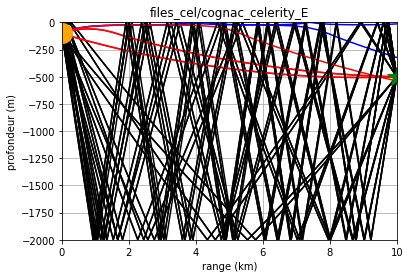

In [22]:
# eigenray plot
dictE = s.plotE ('files_cel/cognac_celerity_E.ray')

plt.plot (0., -s.params['zs'], color='orange', marker='o', markersize=20, label = 'source')
plt.plot (s.params['rmin'], -s.params['zmin'], color='green', marker='*', markersize=20, label = 'receiver')
#plt.ylim (ymin=-550,ymax=-450)
#plt.xlim (xmin=9.9,xmax=10.1)

print('Le fichier E contient %d rayons.' %np.shape(dictE['SrcAngle'])[0])

In [21]:
print('SrcAngle :', dictE['SrcAngle'])
print('\nDistance :', dictE['Dist'])

SrcAngle : [-64.38947195 -64.38857194 -64.38767194 -63.26626633 -59.27654638
 -59.27564638 -57.71863859 -57.71773859 -52.00901005 -52.00811004
 -49.75629878 -49.75539878 -41.3394567  -41.33855669 -38.02204011
 -38.02114011 -25.84407922 -25.84317922 -21.47725739 -21.47635738
  -6.80628403  -6.80538403  -6.80448402  -5.3005765   -5.2996765
   5.43107716   5.43197716  20.6600533   20.6609533   24.99627498
  24.99717499  37.32993665  37.33083665  40.7004535   40.70135351
  49.27749639  49.27839639  51.57160786  51.57250786  57.39013695
  57.39103696  58.97594488  58.97684488  63.02866514  63.02956515
  64.16987085  64.17077085]

Distance : [22899.61405188 22898.97641445 22898.33678643 22003.73438839
 19379.71801466 19379.17475    18530.52096244 18530.0600909
 16086.35530971 16086.02975303 15315.60032389 15315.31104815
 13189.73788761 13189.54382389 12560.64891599 12560.49297419
 11008.2506114  11008.16477606 10629.50293177 10629.43350818
 10018.16246702 10004.11055307 10026.46239646 10014.

# Arrivals calculations

In [9]:
# Generate .env file A
s.params['file_type'] = 'A' 
s.generate_envfile('mediterrannee',file_env = s.params['name']+'_A.env', Issp=issp, SSP_depth_step=50)

Output file is : cognac_celerity_A.env


Max.number of arrivals for source index 0 is 28


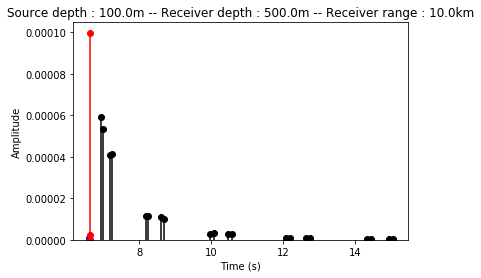

In [10]:
Arr1, Pos1 = s.read_arrivals_asc ('files_cel/cognac_celerity_A.arr')

irr = 0    # choice of receiver range (size of NRange)
ird = 0    # choice of receiver depth (size of NDepth)
isd = 0    # choice of source depth   
Narr = int(Arr1['Narr'][irr, ird, isd])   # number of arrivals

s.plotarr(Arr1, Pos1, irr, ird, isd)
#plt.xlim (xmin = 6.620, xmax = 6.625)

# Link between A (.arr) and E (.ray)

In [11]:
# work on angles at which the ray left the source (pos is down, neg is up)

angles_A = Arr1['SrcAngle'][irr, :Narr, ird, isd]
angles_E = dictE['SrcAngle']

idx_E = np.zeros_like(angles_A)
Diff = np.zeros_like(angles_A)

for i in range (len(angles_A)):
    angle = angles_A[i]
    diff = np.abs(angles_E - angle)
    idx = diff.argmin()
    a = angles_E[idx]
    
    idx_E[i] = idx 
    Diff[i] = angle - a
    
print('La différence max entre les angles E et A est de %e°.' %np.max(Diff))
#print('\nIndices des angles dans E :', idx_E)  

La différence max entre les angles E et A est de 4.498451e-04°.


# Real and equivalent celerities

In [12]:
#estimate of real celerity for arrivals from .arr file

t = Arr1['delay'][irr, :Narr, ird, isd]
d = dictE['Dist']

c_real = np.zeros_like(angles_A)
for i in range (len(c_real)):
    c_real[i] = d[int(idx_E[i])]/t[i]

In [13]:
c_real

array([1521.00605552, 1520.9715023 , 1520.93663467, 1522.00939292,
       1521.25594133, 1521.90392429, 1521.16494166, 1521.79801768,
       1520.96707435, 1522.38059177, 1520.72520587, 1523.69788727,
       1512.79447253, 1519.12656209, 1514.60258679, 1511.90022939,
       1512.09087861, 1523.71245868, 1520.70045234, 1522.41390034,
       1521.03190043, 1521.89247426, 1521.26357052, 1521.92746215,
       1521.2644911 , 1522.22139063, 1522.25362919, 1521.18434155])

In [14]:
# equivalent celerity

sr = 0.                         # source range(m)
sd = Pos1['s']['depth'][isd]    # source depth (m)
rr = Pos1['r']['range'][irr]    #receiver range (m)
rd = Pos1['r']['depth'][ird]    #receiver depth (m)

dist_eq = np.sqrt( (rr-sr)**2 + (rd-sd)**2)
c_eq = dist_eq / t


In [15]:
c_eq

array([ 664.73713076,  664.74053933,  664.74386846,  692.25818077,
        785.60093522,  821.97302833,  946.3805554 ,  994.42068042,
       1154.06642244, 1212.99307039, 1382.55679376, 1434.60740185,
       1511.25940449, 1519.71669   , 1511.81316464, 1510.88766524,
       1511.42863511, 1443.57801822, 1392.89820997, 1224.72582061,
       1165.56325295, 1004.38032121,  955.73648516,  829.51151632,
        792.61065533,  698.01318814,  698.00975112,  670.09430834])

In [16]:
# celerity difference for the arrival with the amplitude max

A = abs(Arr1['A'][irr, :Narr, ird, isd]) 
dC = c_real - c_eq
dC_max = dC [np.where(A==np.max(A))][0]
print("La diff de célérité pour le max d'amplitude est de %.2f m/s." %dC_max)

La diff de célérité pour le max d'amplitude est de 0.66 m/s.
